In [ ]:
cd drive/

[Errno 2] No such file or directory: 'drive/'
/content/drive/My Drive/Plate_detect_and_recognize-master


In [ ]:
cd My\ Drive

[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive/Plate_detect_and_recognize-master


In [ ]:
cd Plate_detect_and_recognize-master/

[Errno 2] No such file or directory: 'Plate_detect_and_recognize-master/'
/content/drive/My Drive/Plate_detect_and_recognize-master


In [ ]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import glob
import math
import statistics
from operator import itemgetter

In [ ]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [ ]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [ ]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path):
    Dmax = 608
    Dmin = 288
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

1


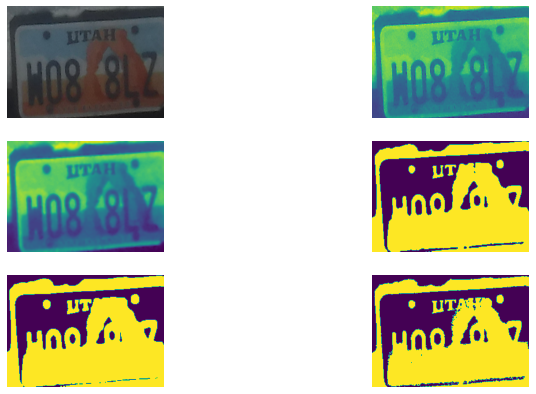

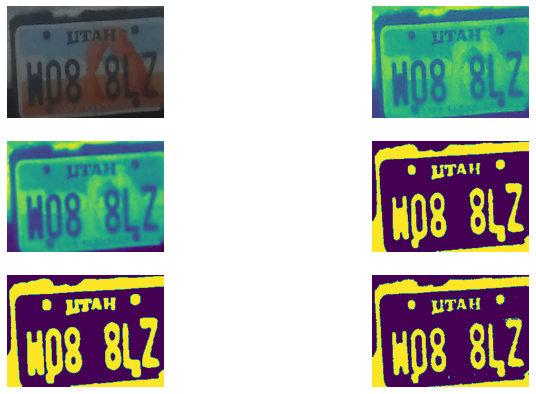

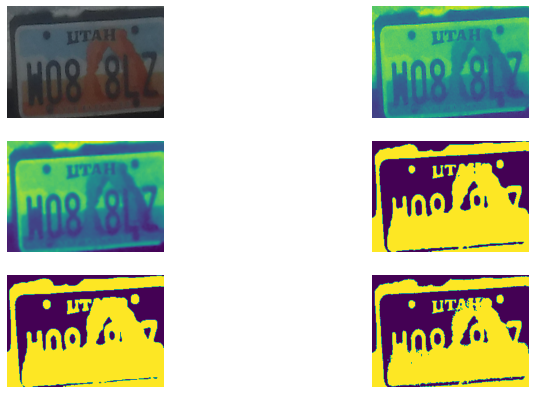

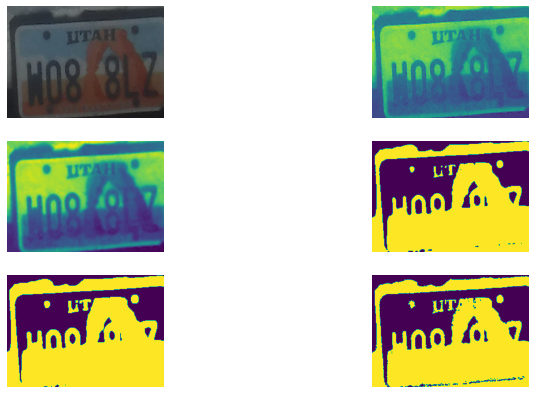

In [ ]:
def basic_method(plate_image):
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    myBinary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return [plate_image, gray, blur, binary, thre_mor, myBinary]

def color_method(colorNumber, plate_image):
  possibleImages = []
  b = plate_image.copy()
  b = b[:, :, colorNumber]
  y = math.floor(b.shape[0]/2.4)
  x = math.floor(b.shape[1]/9)
  crop_img = b[y:int(y*2), x:int(x*8.3)]
  flatArray = b.flatten()
  cangeV =  np.percentile(flatArray, [32])
  image = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  _, binary = cv2.threshold(gray, cangeV, cangeV, cv2.THRESH_BINARY_INV)


  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  blur = cv2.GaussianBlur(gray,(7,7),0)
  
  binary = cv2.threshold(blur, 180, 255,
                        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  
  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
  myBinary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  return [plate_image, gray, blur, binary, thre_mor, myBinary]

def visualize_set(plot_image):
  # visualize results    
  fig = plt.figure(figsize=(12,7))
  plt.rcParams.update({"font.size":18})
  grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
  # plot_name = ["plate_image","gray","blur","binary","dilation"]

  for i in range(len(plot_image)):
      fig.add_subplot(grid[i])
      plt.axis(False)
      # plt.title(plot_name[i])
      plt.imshow(plot_image[i])

def getFilteredPlateImages(path):
  returnArray = []
  test_image_path = path
  vehicle, LpImg,cor = get_plate(test_image_path)
  print(len(LpImg))

  if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.    
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    returnArray.append(basic_method(plate_image))
    for i in range(3):
      returnArray.append(color_method(i,plate_image))
      
  for im in returnArray:
    visualize_set(im)
  return returnArray

# filteredPlateImages =  getFilteredPlateImages("Plate_examples/50States.jpg")
# filteredPlateImages =  getFilteredPlateImages("Plate_examples/germany_car_plate.jpg")
filteredPlateImages =  getFilteredPlateImages("Plate_examples/photo2.JPG")
# filteredPlateImages = getFilteredPlateImages("Plate_examples/easy2.jpg")
# filteredPlateImages =  getFilteredPlateImages("utahPlates/pol3.jpg")

In [ ]:

def splitContour(con):
  midPoint = int((con[3] + con[2])/2)
  con1 = con.copy()
  con1[2] = midPoint
  con2 = con.copy()
  con2[3] = midPoint
  return [con1,con2]


def breakPossibleBranch(curr):
  if abs(curr[0]-curr[1]) < 5 or abs(curr[2]-curr[3]) < 5:
    return []

  workingImage = filteredPlateImages[0][3]

  # digit_w, digit_h = 30, 60

  curr_num = workingImage[curr[0]:curr[1],curr[2]:curr[3]]
  # plt.imshow(curr_num)
  cont, _ =  cv2.findContours(curr_num, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  newContors = []

  for c in sort_contours(cont):
      (x, y, w, h) = cv2.boundingRect(c)
      x += curr[2]
      y += curr[0]
      newContors.append([y,y+h,x,x+w])
  # return newContors

  finalList = []

  while (newContors):
    tempContour = newContors.pop()
    width = tempContour[3] - tempContour[2]
    height = tempContour[1] - tempContour[0]
    if width > 5 and height > 5:
      if width/height > 1:
        smallC = splitContour(tempContour)
        newContors = newContors + smallC
      else:
        finalList.append(tempContour)

  return finalList
#[[43, 71, 128, 151], [43, 71, 106, 128]]

# input = [43, 71, 106, 151]

# print(breakPossibleBranch(input))

[42, 60, 173, 182] [41, 62, 184, 193]
284.65165846463407
Detect 6 letters...


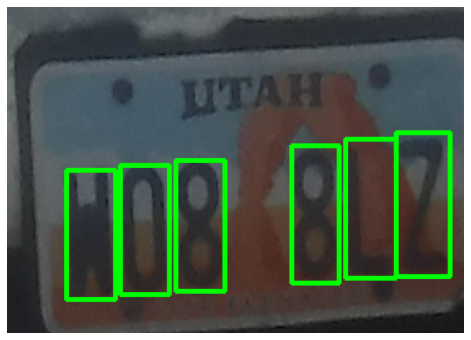

In [ ]:
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

# [[47, 58, 67, 76], [47, 67, 110, 127], [46, 49, 123, 126], [46, 50, 130, 134], [44, 63, 136, 149], [36, 50, 222, 234]]

def cutOutliersNeighboring(inArray):
  if len(inArray) < 2:
    return []
  left = [div[2] for div in inArray]
  right = [div[3] for div in inArray]
  returnArray = []

  for i in range(len(inArray)-2):
    if abs(right[i] - left[i+1]) < 7 or abs(right[i+1] - left[i+2]) < 7:
      if abs(inArray[i][0] - inArray[i+1][0]) < 7 or abs(inArray[i+1][0] - inArray[i+2][0]) < 7:
        returnArray.append(inArray[i+1])
  
  if abs(right[0] - left[1]) < 7:
    if abs(inArray[0][0] - inArray[1][0]) < 7:
      returnArray.append(inArray[0])
  
  if abs(left[-1] - right[-2]) < 7:
    if abs(inArray[-1][0] - inArray[-2][0]) < 7:
      returnArray.append(inArray[-1])
  return returnArray
  

def cutOutliersArea(inPArray):
  # areaArray = [abs(con[1]-con[0]) * abs(con[3]-con[2]) for con in inPArray]
  
  inArray = []
  for con in inPArray:
    height = con[1] - con[0]
    width = con[3] - con[2]
    if height > 7 and width > 4:
      inArray.append(con)
  if len(inArray) == 0:
    return []
  returnArray = []
  reducedArray = [((con[1] - con[0]) * (con[3] - con[2])) for con in inArray]
  mean = statistics.mean(reducedArray)
  stdevi = statistics.stdev(reducedArray)
  print(stdevi)
  if stdevi < 150:
    stdevi = 150
  for i in range(len(inArray)):
    if mean-(stdevi*1.5) < reducedArray[i] < mean+(stdevi*1.5):
      returnArray.append(inArray[i])
  return returnArray

def fineChopLetters(contours):

  contours = cutOutliersArea(contours)
  heightList = []
  go = True
  rScore = .05
  passing = 0
  while(rScore < .9 and passing < 6):
    heightList = []
    heightList = [con[1] - con[0] for con in contours]
    average = np.mean(heightList)
    # if abs(rScore) < .85:
    heightDifList = [abs(cow - average) for cow in heightList]
    indexToRemove = np.argmax(heightDifList)
    xPointOfInterest = np.array([(contours[indexToRemove][2] + contours[indexToRemove][3]) / 2])
    xPointOfInterest = xPointOfInterest.reshape(1,-1)
    tempContorCopy = contours.copy()
    del tempContorCopy[indexToRemove]
    bottomEdge = [((con[2] + con[3])/2, con[0]) for con in tempContorCopy ]
    topEdge = [((con[2] + con[3])/2, con[1]) for con in tempContorCopy ]

    X = [((con[2] + con[3])/2) for con in tempContorCopy ]
    X = np.array(X).reshape((-1, 1))

    model = LinearRegression()

    bottomEdgeY = np.array([con[0] for con in tempContorCopy ])
    model.fit(X, bottomEdgeY)
    newYValue = model.predict(xPointOfInterest)
    contours[indexToRemove][0] = int(newYValue)
    rSq1 = model.score(X, bottomEdgeY)

    topEdgeY = np.array([con[1] for con in tempContorCopy ])
    model.fit(X, topEdgeY)
    newYValue = model.predict(xPointOfInterest)
    contours[indexToRemove][1] = int(newYValue)
    rSq2 = model.score(X, topEdgeY)
    rScore = (rSq1 + rSq2) / 2
    passing += 1
    
  return contours


def getNeighbors(one,two):

  if one[1] - one[0] > 10 and two[1] - two[0] > 10:
    if (one[1] - one[0]) - (two[1] - two[0]) < 10:
      if abs(one[0] - two[0]) < 5 or abs(one[1] - two[1]) < 5:
        if abs(one[2]-two[3]) < 3 or abs(one[3]-two[2]) < 3:
          if abs(one[3]-one[2]) - abs(two[3]-two[2]) < 3:
            return [max(one[0],two[0]), min(one[1],two[1]), min(one[2],two[2]), max(one[3],two[3])]
  return None

def fineChopSmallLetters(contours):
  returnContours = []
  finalReturnContours = []
  if len(contours) >= 3:

    processingContours = contours.copy()
    potentialCombine = []
    # return contours
    while (processingContours):
      tempContour = processingContours.pop()
      width = tempContour[3] - tempContour[2]
      height = tempContour[1] - tempContour[0]
      if width > 3 and height > 8:
        if width/height > 1:
          smallC = breakPossibleBranch(tempContour)
          processingContours = processingContours + smallC
        elif height/width > 1.7:
          potentialCombine.append(tempContour)
        else:
          returnContours.append(tempContour)
    # return returnContours
    if len(potentialCombine) > 1:
      left = [div[2] for div in potentialCombine]
      right = [div[3] for div in potentialCombine]
      potentialCombine = sorted(potentialCombine, key=itemgetter(2))
      combinedContours = []
      for i in range(len(left)-1):
        for two in potentialCombine[i+1:]:
          temp = getNeighbors(potentialCombine[i],two)
          if temp != None:
            print(potentialCombine[i],two)
            combinedContours = combinedContours + [potentialCombine[i],two]
            returnContours.append(temp)
            go = False
        if not potentialCombine[i] in combinedContours:
          returnContours.append(potentialCombine[i])
      if not potentialCombine[-1] in combinedContours:
          returnContours.append(potentialCombine[i])
    elif len(potentialCombine) == 1:
      returnContours.append(potentialCombine[0])
  if len(returnContours) > 2:
    returnContours = sorted(returnContours, key=itemgetter(2))
    returnContours = cutOutliersNeighboring(returnContours)
  return returnContours



def getContorSets(filteredImages):

  contour_sets = []

  for imageSet in filteredImages:
    
    plate_image = imageSet[0]

    binary = imageSet[3]
    thre_mor = imageSet[4]
    myBinary = imageSet[5]

    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi_small_u = plate_image.copy()
    test_roi_small_l = plate_image.copy()
    test_roi = plate_image.copy()

    # Initialize a list which will be used to append charater image
    crop_characters = []
    small_letters_t = []
    small_letters_b = []

    # define standard width and height of character
    digit_w, digit_h = 30, 60

    totalArea = plate_image.shape[0] * plate_image.shape[1]
    # print(plate_image)


    small_letters_list_top = []
    small_letters_list_bottom = []
    
    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        contorArea = x*h
        if (x + w) < plate_image.shape[1] * .95: #only select if width is relatively small
          if y + h < plate_image.shape[0] *.45: #only select contor not in middle
            small_letters_list_top.append([y,y+h,x,x+w])
          if y > plate_image.shape[0] *.55:
            small_letters_list_bottom.append([y,y+h,x,x+w])


    if(len(small_letters_list_top) > 1):
      small_letters_list_top = fineChopSmallLetters(small_letters_list_top)
      for curr in small_letters_list_top:
        cv2.rectangle(test_roi_small_u, (curr[2], curr[0]), (curr[3], curr[1]), (0, 255,0), 2)
        curr_num = myBinary[curr[0]:curr[1],curr[2]:curr[3]]
        curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
        _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        small_letters_t.append(curr_num)

    if(len(small_letters_list_bottom) > 1):
      small_letters_list_bottom = fineChopSmallLetters(small_letters_list_bottom)
      for curr in small_letters_list_bottom:
        cv2.rectangle(test_roi_small_l, (curr[2], curr[0]), (curr[3], curr[1]), (0, 255,0), 2)
        curr_num = myBinary[curr[0]:curr[1],curr[2]:curr[3]]
        curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
        _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        small_letters_b.append(curr_num)

    count = 0
    curr_num_list = []
    for c in sort_contours(cont):
        # cout = count + 1
        # if count == 2
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if .9<=ratio<=4: # Only select contour with defined ratio
          if y < plate_image.shape[0] *.6 and y + h > plate_image.shape[0] *.4: 
            curr_num_list.append([y,y+h,x,x+w])

    if(len(curr_num_list) > 1):
      curr_num_list = fineChopLetters(curr_num_list)
      for curr in curr_num_list:
        cv2.rectangle(test_roi, (curr[2], curr[0]), (curr[3], curr[1]), (0, 255,0), 2)
        curr_num = myBinary[curr[0]:curr[1],curr[2]:curr[3]]
        curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
        _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        crop_characters.append(curr_num)
      print("Detect {} letters...".format(len(crop_characters)))
      fig = plt.figure(figsize=(10,6))
      plt.axis(False)
      plt.imshow(test_roi)
      # plt.imshow(test_roi_small_u)
      # return curr_num_list
      contour_sets.append(small_letters_t)
      contour_sets.append(crop_characters)
  return contour_sets

crop_characters_set = getContorSets(filteredPlateImages)


In [ ]:
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')


0.9999323
0.9700946
0.99931014
0.9981166
UTAH
0.66416824
0.99541324
0.9999993
0.9999995
0.99999964
0.98207307
N088LZ


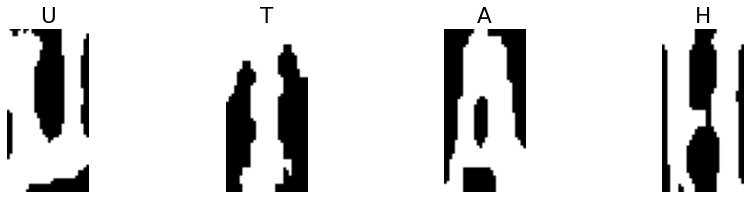

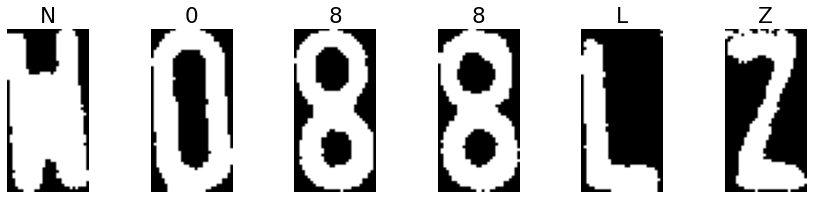

In [ ]:
def predict_from_model(image,model,labels):
    plt.imshow(image)
    # return
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    argument = np.argmax(model.predict(image[np.newaxis,:]))
    predictionArray = model.predict(image[np.newaxis,:])
    pValue = predictionArray[0][argument]
    print(pValue)
    prediction = labels.inverse_transform([np.argmax(predictionArray)])
    if pValue < .4:
      prediction[0] = '*'
    return prediction

def read_letters(crop_characters_set):
  for chop_characters2 in crop_characters_set:
    fig = plt.figure(figsize=(15,3))
    cols = len(chop_characters2)
    grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)


    final_string = ''
    for i,character in enumerate(chop_characters2):
        fig.add_subplot(grid[i])
        title = np.array2string(predict_from_model(character,model,labels))
        plt.title('{}'.format(title.strip("'[]"),fontsize=20))
        final_string+=title.strip("'[]")
        plt.axis(False)
        plt.imshow(character,cmap='gray')

    print(final_string)
read_letters(crop_characters_set)

In [ ]:
#restult with my binary
# 0.9995994
# 0.99752384
# 0.99931014
# 0.9981166
# UTAH
# 0.66416824
# 0.99541324
# 0.9999993
# 0.9999995
# 0.99999964
# 0.98207307
# N088LZ

#result with classic model
# 0.9797974
# 0.99994016
# 0.9990319
# 0.53806275
# UTAH
# 0.89392096
# 0.998555
# 0.9999993
# 0.99999833
# 0.99999857
# 0.9997483
# N088LZ